In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from astropy.cosmology import Planck15
from scipy.interpolate import interp1d
from scipy.special import gamma
import numpy as np
import cv2
from numpy.ma import masked_array
import emcee
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad
import matplotlib.patches as patches
from itertools import product
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
import glob
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
from matplotlib.colors import LogNorm
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from StringIO import StringIO
import datetime
import scipy.ndimage as ndimage
import matplotlib.patches as mpatches
MetalFlag=0

In [3]:
path = "/data/OWN/Mochima/SF0/Stable/output_00041"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myhalo = wkbl.Galaxy_Hound(path,virial=True)
myhalo.r_virial(600)
ok,myhalo.st.rho,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),
                                           dtype=np.float32), myhalo.st.mass)

loading Dark matter..
loading Stars..
loading Gas..
| r_200 = 229.380
---- taking particles inside 2.5 * r200
| number of praticles inside 2.5 * r200 
| dm mass       =  1.066e+12 M_sun
| p_dm_200      =  9.274e+05 particles
| stellar mass  =  1.168e+11 M_sun
| p_st_200      =  5.095e+05 psrticles
| gas mass      =  1.535e+11 M_sun
| p_gs_200      =  2.037e+06 particles
---- rotating galaxy 
| Diagonal matrix computed 
|    |17, 0, 0|
| D =| 0,13, 0|
|    | 0, 0, 2|


In [4]:
cs2 = (0.666*(myhalo.gs.temp2 / myhalo.p.scale_T2 )) * myhalo.p.simutokms**2
cs2[np.where(cs2<=-0)]= 0.01
mach2 = myhalo.gs.sigma2/cs2 
myhalo.gs.M2 = mach2
myhalo.gs.cs2 = cs2
factG = 3. / 4. / 2. / np.pi * 0.3089 * myhalo.p.aexp 
myhalo.gs.alpha0 = 0.5 * myhalo.gs.sigma2 / np.pi / factG / myhalo.gs.rho / (myhalo.gs.hsml)**2


In [5]:
path = "/data/OWN/Mochima/SF0/Stable/output_00040"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
SF0 = wkbl.Galaxy_Hound(path,virial=True)
SF0.r_virial(600)
ok,SF0.st.rho,_= CF.getDensity(np.array(SF0.st.pos3d.reshape(len(SF0.st.pos3d)*3),
                                           dtype=np.float32), SF0.st.mass)

loading Dark matter..
loading Stars..
loading Gas..
| r_200 = 228.575
---- taking particles inside 2.5 * r200
| number of praticles inside 2.5 * r200 
| dm mass       =  1.054e+12 M_sun
| p_dm_200      =  9.288e+05 particles
| stellar mass  =  1.153e+11 M_sun
| p_st_200      =  5.031e+05 psrticles
| gas mass      =  1.548e+11 M_sun
| p_gs_200      =  2.090e+06 particles
---- rotating galaxy 
| Diagonal matrix computed 
|    |17, 0, 0|
| D =| 0,13, 0|
|    | 0, 0, 2|


In [6]:
cs2 = (0.666*(SF0.gs.temp2 / SF0.p.scale_T2 )) * SF0.p.simutokms**2
cs2[np.where(cs2<=0)]= 0.01
mach2 = SF0.gs.sigma2/cs2 
SF0.gs.M2 = mach2
SF0.gs.cs2 = cs2
factG = 3. / 4. / 2. / np.pi * 0.3089 * SF0.p.aexp 
SF0.gs.alpha0 = 0.5 * SF0.gs.sigma2 / np.pi / factG / SF0.gs.rho / (SF0.gs.hsml)**2
n_star_SF0 = 1.92
m_H = 1.67e-27/SF0.p.msuntokg # msun
rhoc_SF0 = n_star_SF0 * m_H / ((SF0.p.cmtopc/1e3)**3) #Msun /kpc^3\

In [7]:
def face_on_gs_M2(sim,lims,points,thikness=4):
    disc = np.where(np.abs(sim.gs.pos3d[:,2])<thikness)
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[disc,0][0], 
                                       sim.gs.pos3d[disc,1][0],
                                       bins=(edges, edges),
                                       weights=1./np.sqrt(sim.gs.M2[disc]))
    result = H.T
    return result, edges

def edge_on_gs_M2(sim,lims,points):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[:,0], 
                                       sim.gs.pos3d[:,2],
                                       bins=(edges, edges),
                                       weights=1./np.sqrt(sim.gs.M2))
    result = H.T
    return result, edges

def face_on_gs_cs2(sim,lims,points,thikness=4):
    disc = np.where(np.abs(sim.gs.pos3d[:,2])<thikness)
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[disc,0][0], 
                                       sim.gs.pos3d[disc,1][0],
                                       bins=(edges, edges),
                                       weights=np.sqrt(sim.gs.cs2[disc]))
    result = H.T
    return result, edges

def edge_on_gs_cs2(sim,lims,points):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[:,0], 
                                       sim.gs.pos3d[:,2],
                                       bins=(edges, edges),
                                       weights=np.sqrt(sim.gs.cs2))
    result = H.T
    return result, edges

def face_on_gs_sig2(sim,lims,points,thikness=4):
    disc = np.where(np.abs(sim.gs.pos3d[:,2])<thikness)
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[disc,0][0], 
                                       sim.gs.pos3d[disc,1][0],
                                       bins=(edges, edges),
                                       weights=np.sqrt(sim.gs.sigma2[disc]))
    result = H.T
    return result, edges

def edge_on_gs_sig2(sim,lims,points):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[:,0], 
                                       sim.gs.pos3d[:,2],
                                       bins=(edges, edges),
                                       weights=np.sqrt(sim.gs.sigma2))
    result = H.T
    return result, edges

def face_on_gs_alpha0(sim,lims,points,thikness=4):
    disc = np.where(np.abs(sim.gs.pos3d[:,2])<thikness)
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[disc,0][0], 
                                       sim.gs.pos3d[disc,1][0],
                                       bins=(edges, edges),
                                       weights=1./sim.gs.alpha0[disc])
    result = H.T
    return result, edges


def edge_on_gs_alpha0(sim,lims,points):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[:,0], 
                                       sim.gs.pos3d[:,2],
                                       bins=(edges, edges),
                                       weights=1./sim.gs.alpha0)
    result = H.T
    return result, edges

In [12]:
myhalo.gs.pos3d *= [1,-1,-1]

<IPython.core.display.Javascript object>


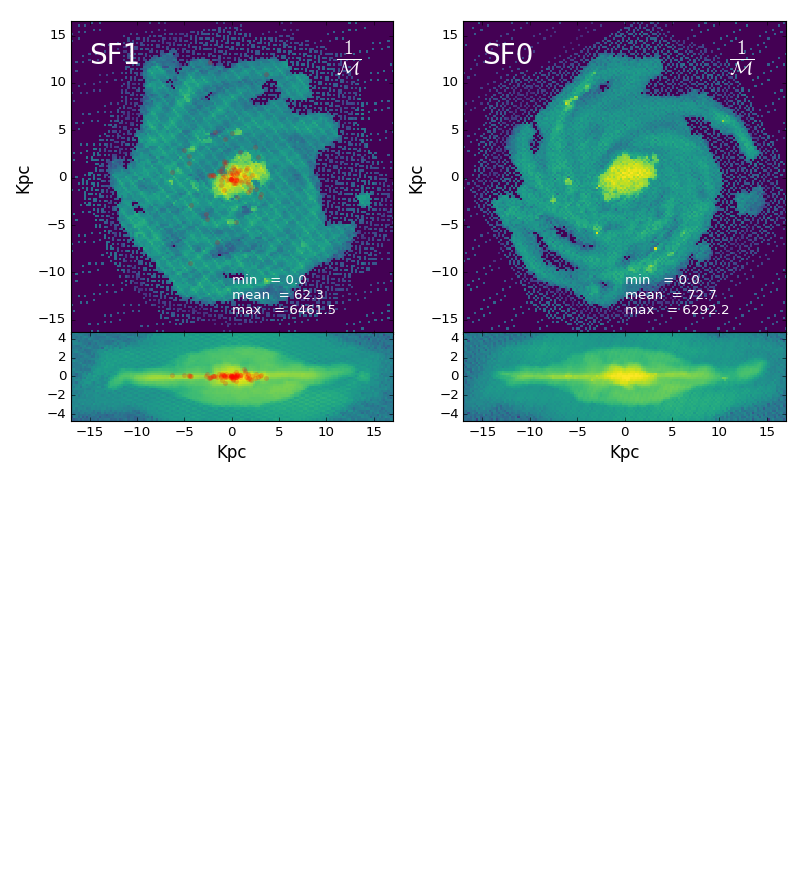

6461.4976806640625
30090.122289180756
6292.1561279296875
33992.7919793129


In [13]:
#fig, [ax,ax1] = plt.subplots(1,2,figsize=[10,5])
fig, [[ax,ax1],[ax2,ax3]] = plt.subplots(2,2,gridspec_kw = {'height_ratios':[3.5, 1,3.5,1]},figsize=[10,11],sharex=True)
length=17
ax.set_ylim([-length,length]);ax.set_xlim([-length,length])
ax2.set_ylim([-length,length]);ax2.set_xlim([-length,length])

SF1140_faceOn,edges= face_on_gs_M2(myhalo,[-length,length],150,thikness=0.2)#H.T 
print SF1140_faceOn.max()
mass_2 = ax.imshow(SF1140_faceOn+0.001, interpolation='nearest', origin='low',cmap='viridis',
                    extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1,vmax=0.9*SF1140_faceOn.max())
                  )
"""
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')
"""
ax.text(-15,12,"SF1",fontsize=25,color='w')
texto =  "min   = {0:.1f}".format(SF1140_faceOn.min())+'\n'
texto += "mean  = {0:.1f}".format(SF1140_faceOn.mean())+'\n'
texto += "max   = {0:.1f}".format(SF1140_faceOn.max())+'\n'
ax.text(0,-16,texto,color='w')
ax.text(11,12,r"$\frac{1}{\mathcal{M}}$",fontsize=25,color='w')


SF1140_faceOn,edges= edge_on_gs_M2(myhalo,[-length,length],150)#H.T 
print SF1140_faceOn.max()
mass_2 = ax2.imshow(SF1140_faceOn+0.001, interpolation='nearest', origin='low',cmap='viridis',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1,vmax=0.9*SF1140_faceOn.max())
                  )

ax.set_ylabel("Kpc",fontsize=15)
ax2.set_xlabel("Kpc",fontsize=15)
SF1140_faceOn,edges= face_on_gs_M2(SF0,[-length,length],150,thikness=0.2)#H.T 
print SF1140_faceOn.max()
mass_2 = ax1.imshow(SF1140_faceOn+0.001, interpolation='nearest', origin='low',cmap='viridis',
                    extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1,vmax=0.9*SF1140_faceOn.max())
                  )
"""
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')
"""
ax1.text(-15,12,"SF0",fontsize=25,color='w')
texto =  "min   = {0:.1f}".format(SF1140_faceOn.min())+'\n'
texto += "mean  = {0:.1f}".format(SF1140_faceOn.mean())+'\n'
texto += "max   = {0:.1f}".format(SF1140_faceOn.max())+'\n'
ax1.text(0,-16,texto,color='w')
ax1.text(11,12,r"$\frac{1}{\mathcal{M}}$",fontsize=25,color='w')
ax1.set_ylabel("Kpc",fontsize=15)
ax3.set_xlabel("Kpc",fontsize=15)
SF1140_faceOn,edges= edge_on_gs_M2(SF0,[-length,length],150)#H.T 
print SF1140_faceOn.max()
mass_2 = ax3.imshow(SF1140_faceOn+0.001, interpolation='nearest', origin='low',cmap='viridis',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1,vmax=0.9*SF1140_faceOn.max())
                  )
youngestSF0 = np.where(SF0.st.age>-0.005)
youngestSF1 = np.where(myhalo.st.age>-0.005)
ax.scatter(myhalo.st.pos3d[youngestSF1,0],myhalo.st.pos3d[youngestSF1,1],lw=0,c='r',alpha=0.2)
ax1.scatter(SF0.st.pos3d[youngestSF0,0],SF0.st.pos3d[youngestSF0,1],
            lw=0,c='r',alpha=0.2)
ax2.scatter(myhalo.st.pos3d[youngestSF1,0],myhalo.st.pos3d[youngestSF1,2],lw=0,c='r',alpha=0.2)
ax3.scatter(SF0.st.pos3d[youngestSF0,0],SF0.st.pos3d[youngestSF0,2],
            lw=0,c='r',alpha=0.2)

fig.tight_layout(h_pad=-1)

In [9]:
print myhalo.st.vphi[(myhalo.st.r<9)&(myhalo.st.r>7)&(np.abs(myhalo.st.pos3d[:,2])<1)].mean(), SF0.st.vphi[SF0.st.r<5].mean()

-38.54434108677548 -16.376560827758034


In [10]:
disc = np.where((myhalo.st.r<8.5)&(myhalo.st.r>7.5)&(np.abs(myhalo.st.pos3d[:,2])<3))
hist40 , bins = np.histogram(myhalo.st.vphi[disc],bins=100)

<IPython.core.display.Javascript object>


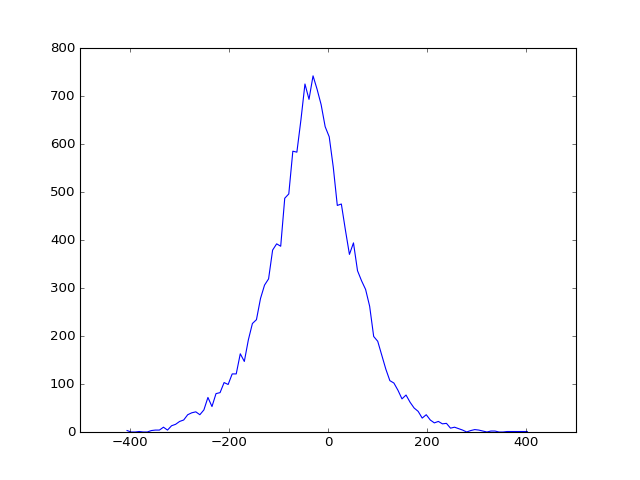

In [11]:
fig, ax= plt.subplots()
ax.plot(bins[:-1],hist40)

In [68]:
a = np.array([1,1,1,1,1])
b = np.array([2,2,2,2,2])
c = np.array([3,3,3,3,3])
cc = np.column_stack([a,b,c])

In [78]:
np.sum(cc**2, axis=1)

array([14, 14, 14, 14, 14])

In [107]:
uni = (myhalo.st.pos3d * [-1,1,1]) / np.column_stack([myhalo.st.r,myhalo.st.r,myhalo.st.r])
phi = np.sum(myhalo.st.vel3d * uni,axis=1)
phi.mean()

-64.36708785146979